In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import NaN
import numpy as np

sns.set_style("white")

%matplotlib inline

## Load and clean data

In [69]:
df = pd.read_csv('data/burgers.csv', encoding='utf-8').fillna(0)

In [70]:
df["Year"].unique()

array([2022, 2021, 2018, 2017, 2015, 2014, 2016, 2019, 2020])

In [71]:
df.columns = [name.strip().lower() for name in df.columns]

Some of the descriptions got all weird and duplicated in one of the spreadsheets, so I gotta fix it.

In [72]:
def snip(text):
    index = text[20:].find(text[:20])
    if index > 0:
        return text[:index+20]
    else:
        return text
    
df['burger description'] = df['burger description'].apply(snip)

In [73]:
df[df.columns[-12:]] = df[df.columns[-12:]].replace({'Yes': 1})

In [74]:
df['price'] = df.price.astype(str).apply(lambda x: float(x.replace('$',''))).replace(0, 20)

In [75]:
df['other'] = (df[['chicken', 'beef', 'pork', 'lamb', u'seafood']].sum(axis=1) == 0)*1

In [76]:
def grams(t):
    return [t.lower()[0:i] for i in range(len(t)+1)]

def substring_match(a, b):
    g_a = grams(a)
    g_b = grams(b)
    matches = [len(g) for g in g_a if g in g_b]
    if len(matches) > 0:
        return max(matches)
    else:
        return 0

In [77]:
restaurants = df["restaurant"].unique()
restaurants = restaurants[pd.Series(restaurants).str.len().argsort()] #sort shortest to longest

In [78]:
matches = [[substring_match(r1, r2) for r2 in restaurants] for r1 in restaurants]
matches = pd.DataFrame(matches, index=restaurants, columns=restaurants)

In [79]:
target = restaurants[16]

In [80]:
m = matches.loc[target]
m.loc[(m > len(target) / 2) & (m > 3)]

olive    5
Olive    5
Name: olive, dtype: int64

## Some Descriptive Stats

In [181]:
df.groupby('year')['price'].sum()

year
2014    1060.5
2015    1687.0
2016    2429.5
2017    2569.5
2018    3779.0
2019    4967.0
2020    5326.0
2021    5888.0
2022    5207.0
Name: price, dtype: float64

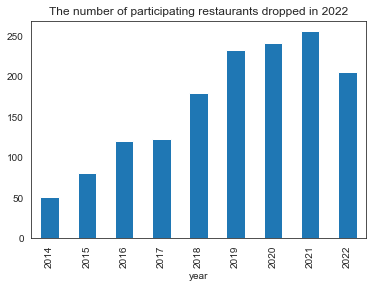

In [172]:
vals = df.groupby('year')['restaurant'].count().rename("Burgers")

vals.plot(kind="bar")
plt.title("The number of participating restaurants dropped in 2022")
plt.savefig('burger_counts.png', bbox_inches='tight', facecolor='white')
plt.show()

In [82]:
# 600 X 335 pixels

x_dim = 600/80
y_dim = 335/80

In [83]:
inflation_adjustments = {k: v for k, v in [[2014,1],
[2015,1.01],
[2016,1.01],
[2017,1.02],
[2018,1.04],
[2019,1.06],
[2020,1.08],
[2021,1.09],
[2022,1.17]]}

In [84]:
df["inflation_adjusted_price"] = df["price"] * (1/df["year"].map(inflation_adjustments))

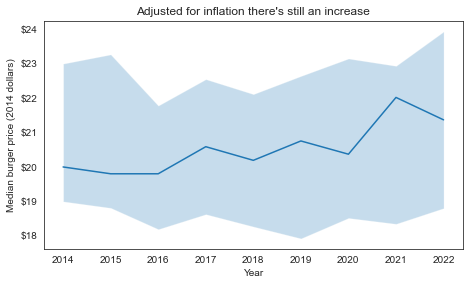

In [170]:
def l(x):
    return x.quantile(q=0.25)

def m(x):
    return x.quantile(q=0.5)

def h(x):
    return x.quantile(q=0.75)

vals = df.groupby('year')['inflation_adjusted_price'].agg([l, m, h]).reset_index().set_index("year")
r = range(15, 26)
plt.yticks(r, ["$"+str(i) for i in r])

plt.fill_between(vals.index, vals["h"], vals["l"], alpha=0.25)
vals["m"].plot(figsize=(x_dim, y_dim))
plt.title("Adjusted for inflation there's still an increase")
plt.ylabel("Median burger price (2014 dollars)")
plt.xlabel("Year")
plt.savefig('inflation_adjusted_price.png', bbox_inches='tight', facecolor='white')
plt.show()

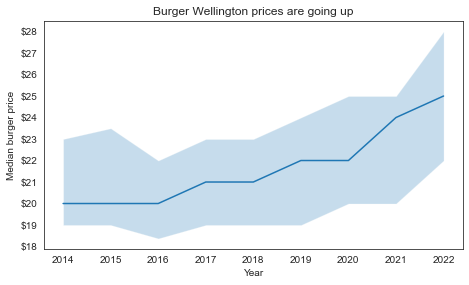

In [174]:
def l(x):
    return x.quantile(q=0.25)

def m(x):
    return x.quantile(q=0.5)

def h(x):
    return x.quantile(q=0.75)

vals = df.groupby('year')['price'].agg([l, m, h]).reset_index().set_index("year")
r = range(15, 30)
plt.yticks(r, ["$"+str(i) for i in r])

plt.fill_between(vals.index, vals["h"], vals["l"], alpha=0.25)
vals["m"].plot(figsize=(x_dim, y_dim))
plt.title("Burger Wellington prices are going up")
plt.ylabel("Median burger price")
plt.xlabel("Year")
plt.savefig('price.png', bbox_inches='tight', facecolor='white')
plt.show()

In [175]:
vals.loc[]

,l,m,h
year,,,
2014,19.000,20.0,23.0
2015,19.000,20.0,23.5
2016,18.375,20.0,22.0
2017,19.000,21.0,23.0
2018,19.000,21.0,23.0
2019,19.000,22.0,24.0
2020,20.000,22.0,25.0
2021,20.000,24.0,25.0
2022,22.000,25.0,28.0


In [87]:
from math import floor

(df["price"] - df["price"].apply(floor)).value_counts()

0.0    1435
0.5      52
0.9       5
Name: price, dtype: int64

In [88]:
df.iloc[277]

burger name                                                       The Rescued
burger description          Wild shot tahr patty with American cheddar, re...
restaurant                                             Everybody Eats at LTD.
price                                                                    20.0
year                                                                     2021
beef                                                                        0
chicken                                                                     0
duck                                                                        0
lamb                                                                        0
pork                                                                        0
seafood                                                                     0
venison                                                                     0
vegetarian                                                      

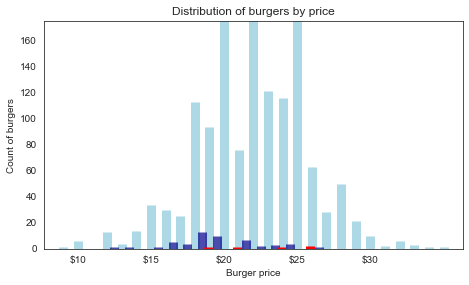

In [89]:
vals = df.loc[df["price"] <= 35]["price"].value_counts().sort_index().reset_index()

plt.figure(figsize=(x_dim,y_dim))
for price, count in vals.values:
    if price - floor(price) == 0:
        c = "lightblue"
        z =1
        a=1
    elif price - floor(price) == 0.5:
        c = "darkblue"
        z = 2
        a=0.7
    else:
        c = "red"
        z = 3
        a = 1
    plt.plot([price, price], [0, count], c=c, linewidth=9, solid_capstyle="butt", zorder=z, alpha=a)
r = range(10, 35, 5)
plt.ylim(0, 175)
plt.ylabel("Count of burgers")
plt.xlabel("Burger price")
plt.title("Distribution of burgers by price")
plt.xticks(r, ["$"+str(i) for i in r])
plt.savefig('price_dist.png', bbox_inches='tight')
plt.show()

## Charts

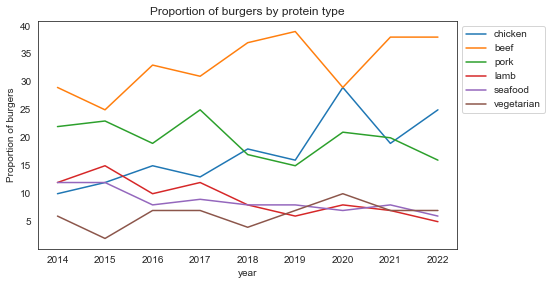

In [176]:
cols = ['chicken', 'beef', 'pork', 'lamb', u'seafood', 'vegetarian']

(df.groupby('year')[cols].sum()\
         /df.groupby('year')[cols].count()).multiply(100).round(0)\
        .plot(figsize=(x_dim, y_dim))
plt.title('Proportion of burgers by protein type')
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Proportion of burgers")
plt.xticks([year for year in range(2014, 2023)])
plt.savefig('patties.png', bbox_inches='tight', facecolor='white')

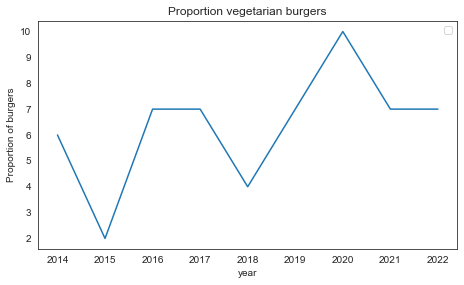

In [91]:
cols = ['vegetarian']

(df.groupby('year')[cols].sum()\
         /df.groupby('year')[cols].count()).multiply(100).round(0)\
        .plot(figsize=(x_dim, y_dim))
plt.title('Proportion vegetarian burgers')
plt.legend("")
plt.ylabel("Proportion of burgers")
#plt.xticks([year for year in range(2014, 2021)])
plt.savefig('vegetarian.png', bbox_inches='tight')

In [92]:
(df.groupby('year')[cols].sum()/df.groupby('year')[cols].count()).round(2)

,vegetarian
year,
2014,0.06
2015,0.02
2016,0.07
2017,0.07
2018,0.04
2019,0.07
2020,0.10
2021,0.07
2022,0.07


In [179]:
year_counts = df.groupby('year')['burger description'].count().values
years = [str(year) for year in range(2014, 2023)]

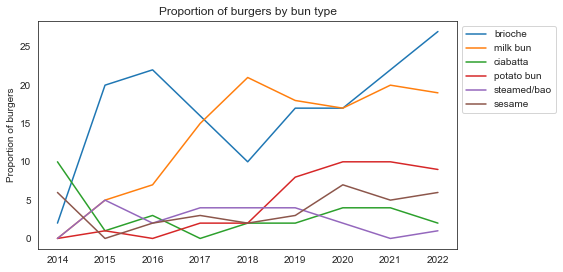

In [180]:

buns = ['brioche', 'milk bun', 'bao', 'steamed bun', 'ciabatta', 'sesame bun', 'sesame seed bun', 'potato bun']
bun_counts = [df['burger description'].str.contains(bun).groupby(df.year).sum().values for bun in buns]
bun_totals = df['burger description'].str.contains(' bun').groupby(df.year).sum().values

bun_df = (pd.DataFrame(bun_counts, index=buns, columns=years).transpose()).div(year_counts, axis=0)
bun_df['steamed/bao'] = bun_df['bao'] + bun_df['steamed bun']
bun_df['sesame'] = bun_df['sesame bun'] + bun_df['sesame seed bun']
bun_df = bun_df[[c for c in bun_df.columns if c not in ['steamed bun', 'bao', 'sesame seed bun', 'sesame bun']]]

bun_df.multiply(100).round(0).plot(figsize=(x_dim, y_dim))
plt.title('Proportion of burgers by bun type')
plt.ylabel("Proportion of burgers")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('buns.png', bbox_inches='tight', facecolor='white')

In [95]:
buns = ['squid-ink bun', 'squid ink bun', 'charcoal bun']
bun_counts = [df['burger description'].str.contains(bun).groupby(df.year).sum().values for bun in buns]
#bun_totals = df['burger description'].str.contains(' bun').groupby(df.year).sum().values

<AxesSubplot:>

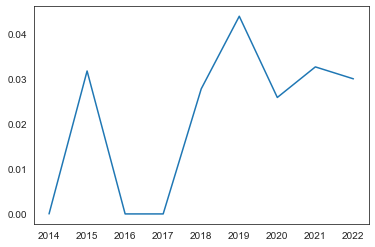

In [96]:
(pd.DataFrame(bun_counts, index=buns, columns=years).sum()/bun_totals).plot()

In [97]:
list((bun_totals / year_counts))

[0.6862745098039216,
 0.7777777777777778,
 0.775,
 0.8373983739837398,
 0.8,
 0.8798283261802575,
 0.9586776859504132,
 0.95703125,
 0.970873786407767]

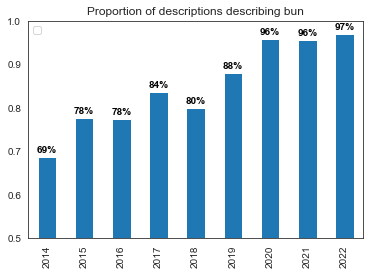

In [98]:
pd.DataFrame((bun_totals / year_counts), index=range(2014, 2023)).plot(kind='bar')
#plt.xticks([year for year in range(2014, 2020)])

for i, value in enumerate(list((bun_totals / year_counts))):
    plt.annotate(str(int(round(value*100))) + '%', xy=(i, value+0.01), color='black', fontweight='bold', ha='center')
plt.legend('')
plt.ylim(0.5, 1)
plt.title('Proportion of descriptions describing bun')
plt.savefig('bun_descriptions.png', bbox_inches='tight')
plt.show()

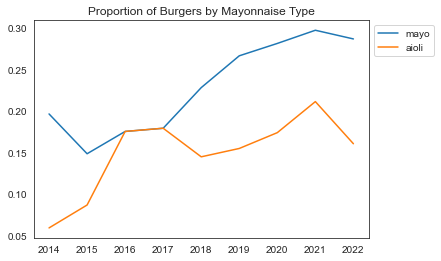

In [99]:
mayos =  ['mayo', 'aioli']
mayo_counts = [df['burger description'].str.contains(mayo).groupby(df.year).sum().values for mayo in mayos]
mayo_df = (pd.DataFrame(mayo_counts, index=mayos, columns=years).transpose()).div(year_counts, axis=0)
mayo_df.plot()
plt.title('Proportion of Burgers by Mayonnaise Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('mayo.png', bbox_inches='tight')

In [100]:
potato_buns = df['burger description'].str.contains('potato bun').groupby(df.year).sum().values

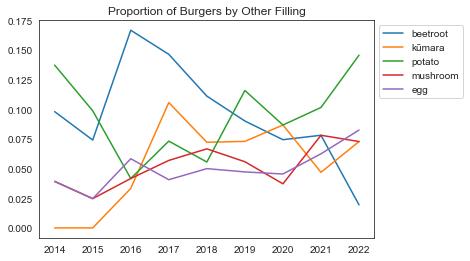

In [101]:
others =  ['beetroot', u'kūmara', 'potato', 'mushroom', 'egg']
counts = [df['burger description'].str.contains(thing).groupby(df.year).sum().values for thing in others]
other_df = (pd.DataFrame(counts, index=others, columns=years).transpose())
other_df['potato'] -= potato_buns
other_df.div(year_counts, axis=0).plot()
plt.title('Proportion of Burgers by Other Filling')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('other_fillings.png', bbox_inches='tight')
plt.show()

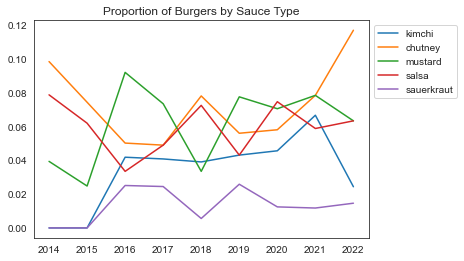

In [102]:
others =  ['kimchi', u'chutney', 'mustard', 'salsa', 'sauerkraut']
counts = [df['burger description'].str.contains(thing).groupby(df.year).sum().values for thing in others]
other_df = (pd.DataFrame(counts, index=others, columns=years).transpose()).div(year_counts, axis=0)
other_df.plot()
plt.title('Proportion of Burgers by Sauce Type')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('sauces.png', bbox_inches='tight')
plt.show()

## Pull out ingredients

In [103]:
from nltk import word_tokenize, pos_tag, RegexpParser
from sklearn.feature_extraction.text import CountVectorizer

We define a "grammar" which is a regex-like pattern for identifying noun-phrases. This one means something like "Any number of contiguous nouns, plural nouns, or adjectives".

In [104]:
grammar = ('''
    NP: {(<NN>|<NNS>|<JJ>)*}
    ''')

chunker = RegexpParser(grammar)

Then we can define a method which does a tiny bit of cleaning, then tags the text and identifies noun phrases.

In [105]:
def noun_phrases(text, chunker=chunker):
    text = text.replace("'", '')
    parsed = chunker.parse(pos_tag(word_tokenize(text)))
    return [' '.join([i[0] for i in subtree.leaves()]) for subtree in parsed.subtrees() if subtree.label() == 'NP']

Here's an example of how it works:

In [106]:
text = df['burger description'][99]
text

'Confit free range ham hock with chocolate syrup drenched bacon, white chocolate truffle, honey and spiced Smoke & Oakum Gunpowder Rum in a freeze dried mānuka and Whittaker’s dark chocolate French toast Zaida’s brioche bun'

In [107]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simoncarryer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [108]:
noun_phrases(text)

['free range ham hock',
 'chocolate syrup',
 'bacon',
 'white chocolate truffle',
 'honey',
 'freeze',
 'mānuka',
 'dark chocolate French toast',
 'brioche bun']

A cool thing is that we can pass that method straight to a Count Vectorizer object, to create a bag-of-words dataframe - a table with a column for each noun phrase and a row for each burger.

In [109]:
countvec = CountVectorizer(tokenizer=noun_phrases)
nouns = countvec.fit_transform(df['burger description'])
nouns_df = pd.DataFrame(nouns.toarray(), columns=countvec.get_feature_names())

/Users/simoncarryer/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [110]:
nouns_df.sum(axis=1).groupby(df['year']).sum()

year
2014     393
2015     671
2016     982
2017    1069
2018    1309
2019    2037
2020    2224
2021    2431
2022    2042
dtype: int64

In [149]:
year_counts = nouns_df.groupby(df["year"]).sum().T.divide(df["year"].value_counts(), axis=1)

In [152]:
year_counts.subtract(year_counts.mean(axis=1), axis=0)[2022]

% chocolate              -0.000434
% dark chocolate jus     -0.000617
% dark ghana             -0.000434
* available              -0.000918
10-hour                   0.004315
                            ...   
ōtaki beetroot ketchup   -0.002179
ōtaki cucumber           -0.000459
ōtaki potato chips       -0.001372
’ s                       0.004315
’ s milk bun              0.004315
Name: 2022, Length: 6043, dtype: float64

In [154]:
(
    year_counts.subtract(year_counts.mean(axis=1), axis=0)[2022]
    .sort_values(ascending=False)[:10]
)

lettuce                    0.055268
cheddar                    0.042662
beef patty                 0.041099
pickles                    0.039992
iceberg                    0.036848
brezelmania brioche bun    0.035980
onion                      0.035288
mozzarella                 0.035006
brioche bun                0.034693
american cheese            0.033961
Name: 2022, dtype: float64

In [159]:
year_counts.loc["onion"]

2014    0.039216
2015    0.024691
2016    0.058333
2017    0.024390
2018    0.016667
2019    0.060086
2020    0.041322
2021    0.039062
2022    0.077670
Name: onion, dtype: float64

## Picking Winners

We're going to calculate the "Uniqueness" of each ingredient, and then see if finalist burgers are more unique than non-finalists.

In [160]:
uniqueness_index = (nouns_df / nouns_df.sum()).replace(0, NaN).mean(axis=1)

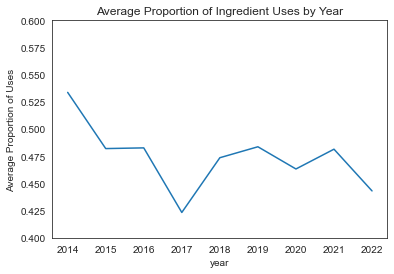

In [163]:
uniqueness_index.groupby(df.year).mean().plot()
plt.xticks([year for year in range(2014, 2023)])
plt.ylim(0.4, 0.6)
plt.title('Average Proportion of Ingredient Uses by Year')
plt.ylabel('Average Proportion of Uses')
plt.savefig('uniqueness_by_year.png')

In [68]:
df['burger description'].iloc[uniqueness_index.loc[df['year'] == 2019].sort_values(ascending=False).index[1]]

'Beer-battered fish with a seasonal crunchy slaw and homemade tartare sauce, on a freshly baked sesame bagel.'

In [69]:
actual = uniqueness_index.groupby(df.finalist).mean()

The observed difference in the dataset is -3.9. In other words, the ingredients in finalist burgers were, on average, used in 60% fewer other burgers, or four burgers on averge.

In [70]:
actual[1] / actual[0]

1.152236856032846

We can use a quick-and-dirty Bayesian technique to measure significance. We randomly shuffle the data and measure the difference each time. If the difference is significant, we should see the observed difference fall well outside the bell-curve of the random differences.

In [71]:
differences = []
for i in range(5000):
    randoms = np.random.rand(len(uniqueness_index)) <= 22/555.0
    grouped = uniqueness_index.groupby(randoms).mean()
    differences.append(grouped[0] - grouped[1])

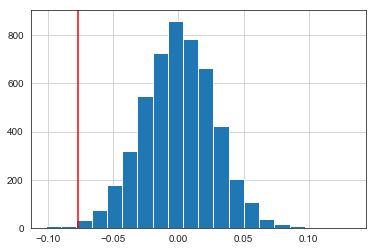

In [72]:
pd.Series(differences).hist(bins=20)
plt.axvline(x=actual[0]-actual[1], c='r')
plt.show()

Another way to visualise this is to look at the proportion of random results that were less than the observed difference:

In [73]:
from math import floor

(pd.Series([floor(abs(i)) for i in differences]).value_counts()/len(differences)).cumsum()

0    1.0
dtype: float64

In [74]:
(np.array(differences) > actual[0]-actual[1]).sum()/5000.0

0.997

## Typical Burgers by Year

Here's my nasty and uncientific way of doing this:

In [165]:
total = nouns_df.sum().loc[nouns_df.sum()>=5]
year = nouns_df.groupby(df.year).sum().loc[2022][nouns_df.sum()>=5]
(year/total).sort_values(ascending=False)[:10]

lime mayonnaise       0.800000
zaida ’ s milk bun    0.714286
baby cos              0.666667
chuck                 0.600000
bbq                   0.555556
spicy                 0.555556
tobacco onions        0.555556
tofu                  0.555556
chimichurri           0.500000
baxters               0.500000
dtype: float64

In [84]:
df.loc[df["burger description"].str.contains("butter pickles")]["burger description"].values

array(['Brisket patty with bourbon and bacon jam, Zany Zeus jalapeño popper and bread and butter pickles in an Arobake cornbread-style bun, with fries and chilli aioli (NF)',
       'Beef patty with smoked cheese, American cheese, griddled onions, snap bacon, bread and butter pickles and secret sauce in a housebaked milk bun with fries (NF).',
       'Smoked brisket patty with pastrami, mustard sauce, housemade bread and butter pickles and smoked barbeque sauce in a Brezelmania potato bun, with kettle chips and cheese fondue dip.',
       'Beer-battered tarakihi with crayfish mayonnaise, bread and butter pickles, Kāpiti cheddar, and iceberg in a Brezelmania sesame bun, with salt and vinegar crinkle-cut fries.',
       'Char-grilled beef patty with melted Kingsmeade Wairarapa Jack, slow-roasted beef cheeks marinated in Smoke and Oakum Gunpowder Rum, parmesan crusted ox tongue, green goddess aioli,  housemade bread and butter pickles and fried onion rings in a Borough Bakery sourdough bu

In [428]:
df.sort_values("price", ascending=False).head(20)

,burger name,burger description,restaurant,price,year,beef,chicken,duck,lamb,pork,seafood,sweet,vegetarian,venison,not your usual,finalist,winner,other,inflation_adjusted_price
901,East Meats West,Slow-cooked St. Louis-style pork rib rack with...,Mac's Brewbar,100.0,2020,0,0,0,0,1,1,0,0,0,0,0,0,0,92.592593
639,Bourgeois Burger High Tea,Burger High Tea including Zelati’s cookie s'mo...,Hippopotamus Restaurant,45.0,2019,0,0,0,0,0,0,0,0,0,1,0,0,1,42.452830
686,Oh La La,Beef patty stuffed with braised beef short rib...,One80 Restaurant,33.0,2019,1,0,0,0,0,0,0,0,0,0,0,0,0,31.132075
873,Lucky Number 8,"Crayfish patty with Ōtaki pork patty, cos lett...",Hot Sauce,32.0,2020,0,0,0,0,1,1,0,0,0,0,0,0,0,29.629630
225,Kai Moana Mini Burgers,Three seafood sliders: Pāua fritter with wasab...,Hippopotamus Restaurant,32.0,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,31.372549
406,The Game Changer,Riverbank Market venison burger with house-cur...,Matterhorn,32.0,2014,0,0,0,0,0,0,0,0,1,0,0,0,1,32.000000
798,"Wagyu, Truffle and Bordelaise",Wagyu chuck with truffle flavoured Zany Zeus m...,Atlas,30.0,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,27.777778
1023,The Stra-BURG-anza 3rio,Three sliders three ways\n1. Spit-roasted mari...,Wildfire Churrascaria,30.0,2020,1,1,0,0,1,0,0,0,0,0,0,0,0,27.777778
313,Black and Gold,"Pāuā patty with cucumber, baby cos and lemon m...",Boulcott Street Bistro,29.0,2015,0,0,0,0,0,1,0,0,0,0,0,0,0,28.712871
490,The BBW,"Wairarapa wagyu beef with baby watercress, Kāp...",Muse eatery & bar,29.0,2016,1,0,0,0,0,0,0,0,0,0,0,0,0,28.712871
